## Business Case: Build a classifier model to predict the credit card defaulter for given dataset
## Task: Credit Card Defaulter Dataset


In [1]:
#Installing xgboost as this will be  required for our analysis

!pip install xgboost

# 1. 1.	Import Libraries/Dataset 

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity="all"

#basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#machine learning libraries
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#importing metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score,f1_score,roc_auc_score
from sklearn.model_selection import cross_val_predict



In [3]:
#Importing the dataset
df=pd.read_csv("Data/credit_card_defaulter.csv")

In [4]:
df.head()

,Unnamed: 0,default,student,balance,income
0,1,No,No,729.526495,44361.62507
1,2,No,Yes,817.180407,12106.13470
2,3,No,No,1073.549164,31767.13895
3,4,No,No,529.250605,35704.49394
4,5,No,No,785.655883,38463.49588


In [5]:
#Dropping the unnecessary column Unnamed: 0
df=df.drop("Unnamed: 0",axis=1)

In [6]:
df.head()

,default,student,balance,income
0,No,No,729.526495,44361.62507
1,No,Yes,817.180407,12106.13470
2,No,No,1073.549164,31767.13895
3,No,No,529.250605,35704.49394
4,No,No,785.655883,38463.49588


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   default  10000 non-null  object 
 1   student  10000 non-null  object 
 2   balance  10000 non-null  float64
 3   income   10000 non-null  float64
dtypes: float64(2), object(2)
memory usage: 312.6+ KB


### There are total 4 columns, 10000 entries and datatypes are object and float, memory usage is 312.6+ KB

In [8]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
balance,10000.0,835.374886,483.714985,0.000000,481.731105,823.636973,1166.308387,2654.322576
income,10000.0,33516.981876,13336.639563,771.967729,21340.462905,34552.644800,43807.729275,73554.233500


#### The mean balance is 835.374886 and mean income is 33516.981876. the standard deviation for balance is 483.714985 and standards deviation for income is 13336.693563.

# 2. Data Visualisation and Augmentation 

## Exploratory Data Analysis to understand the data

In [9]:
#we obtain the coulmns in the dataset
df.columns

Index(['default', 'student', 'balance', 'income'], dtype='object')

In [10]:
#separating out categorical features through a function
cat_feat=[feature for feature in df.columns if df[feature].dtype=='O']
print(cat_feat)

['default', 'student']


In [11]:
df[['default', 'student']].head()

,default,student
0,No,No
1,No,Yes
2,No,No
3,No,No
4,No,No


In [12]:
#the number of observations in each category for default
df['default'].value_counts()

No     9667
Yes     333
Name: default, dtype: int64

In [13]:
df['student'].value_counts()

No     7056
Yes    2944
Name: student, dtype: int64

<Figure size 720x360 with 0 Axes>

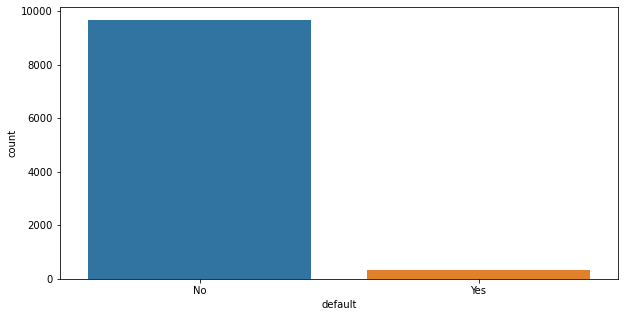

<Figure size 720x360 with 0 Axes>

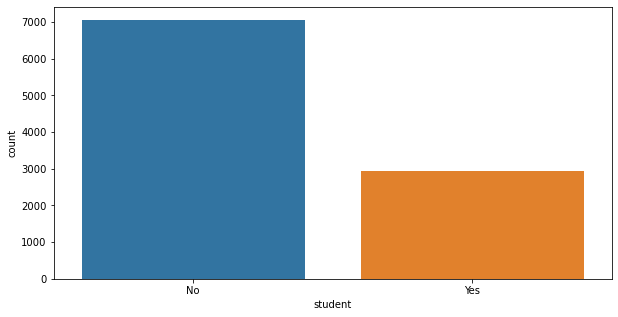

In [14]:
cat_feat1=[feature for feature in cat_feat if len(df[feature].unique())<10]
for feature in cat_feat1 :
    plt.figure(figsize = (10, 5))
    sns.countplot(df[feature])
    plt.show()

#### Observations from the categorical columns in the dataset
1. We observe that there are two categories for default as well as student. 
2. The default feature is clearly unbalanced with majority observations under default
3. The number of students are much less than the non-students

In [15]:
#numerical features in the dataset
num_feat=[feature for feature in df.columns if df[feature].dtype!='O']
print(num_feat)

['balance', 'income']


In [16]:
#We see the observations with only numerical columns
df[['balance','income']].head()

,balance,income
0,729.526495,44361.62507
1,817.180407,12106.13470
2,1073.549164,31767.13895
3,529.250605,35704.49394
4,785.655883,38463.49588


<Figure size 576x360 with 0 Axes>

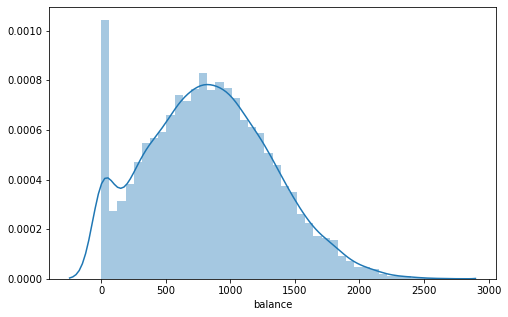

<Figure size 576x360 with 0 Axes>

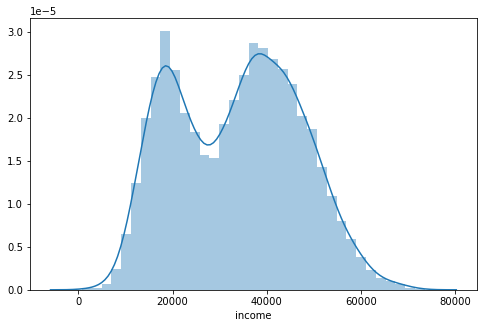

In [17]:
num_feat=[feature for feature in num_feat ]
for feature in num_feat :
    plt.figure(figsize = (8, 5))
    sns.distplot(df[feature],hist=True,kde=True)
    plt.show()

#### Observations:
1. We find that the distribution of income is bimodal

#### Now we try to check the relation between all the and our Target variable which is 'default'

<Figure size 360x360 with 0 Axes>

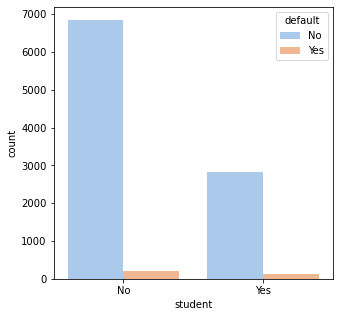

In [18]:
plt.figure(figsize = (5, 5))
sns.countplot(x=df['student'],hue=df['default'],palette='pastel')
plt.show()

### Observations:
1. We see in the non-defaulter group , the number of students is very low. 
2. While in the default group, the number of students and non-students are more or less equal


<Figure size 360x360 with 0 Axes>

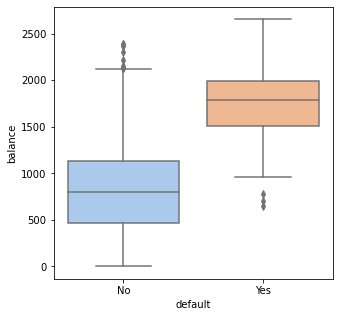

<Figure size 360x360 with 0 Axes>

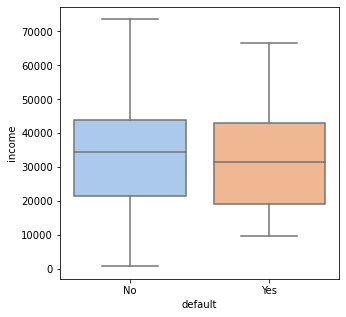

In [23]:
num_feat=[feature for feature in num_feat ]
for feature in num_feat:
    plt.figure(figsize = (5, 5))
    sns.boxplot(x=df['default'],y=df[feature],palette='pastel')
    plt.show()

#### Observations:
1. The median balance of defaulters are much more than that of non-defaulters
2. We find that the median income of both defaulters and non-defaulters are more or less similar.
3. There are presence of outliers in balance for both defaulters and non-defaulters

### Now we prepare our data for further analysis:
1. Check for null values
2. Remove the outliers
3. Convert categorical variables into label encoders
4. Scaling our data
5. separate the data into training and testing set

In [25]:
# Check for null values
df.isnull().sum()

default    0
student    0
balance    0
income     0
dtype: int64

##### No null values are present

In [29]:
q1,q3=np.percentile(df['balance'],[25,75])
q1
iqr=q3-q1
lower_bound=q1-1.5*iqr
upper_bound=q3+1.5*iqr
len(df[(df['balance']<=upper_bound)&(df['balance']>=lower_bound)])/len(df)

481.73110505

0.9969

In [30]:
##nearly 1 % of my data is outlier, so we remove the outlier
df=df[(df['balance']<=upper_bound)&(df['balance']>=lower_bound)]
df.reset_index(drop=True,inplace=True)

<Figure size 360x360 with 0 Axes>

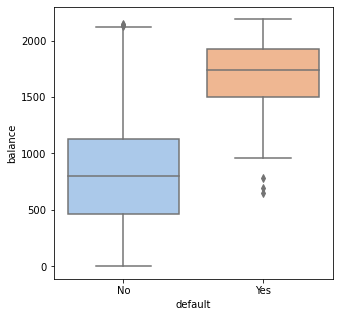

In [32]:
plt.figure(figsize = (5, 5))
sns.boxplot(x=df['default'],y=df['balance'],palette='pastel')
plt.show()

#### Now we perform Label encoding

In [33]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df['default']= label_encoder.fit_transform(df['default'])
df['default'].unique()

array([0, 1])

In [35]:
df['student']= label_encoder.fit_transform(df['student'])
df['student'].unique()

array([0, 1])

In [36]:
df.head()

,default,student,balance,income
0,0,0,729.526495,44361.62507
1,0,1,817.180407,12106.13470
2,0,0,1073.549164,31767.13895
3,0,0,529.250605,35704.49394
4,0,0,785.655883,38463.49588


#### segregating the data into target variable and independent variables

In [48]:
X = df.drop('default',axis=1) # Features for predicting
y = df['default'] # Target class

#### Bring the train and test data in the required format

In [49]:
#Splitting into training and testing data
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,random_state=10)

#### Print the shapes of train and test data

In [51]:
print("X_train:",X_train.shape)
print("Y_train:",y_train.shape)
print("X_test:",X_test.shape)
print("Y_test:",y_test.shape)

X_train: (7975, 3)
Y_train: (7975,)
X_test: (1994, 3)
Y_test: (1994,)


#### Perform scaling of data

In [53]:
scaler=StandardScaler()
X_train_scaled=scaler.fit_transform(X_train)
X_test_scaled=scaler.fit_transform(X_test)

In [54]:
print("X_train_scaled:",X_train_scaled.shape)
print("Y_train:",y_train.shape)
print("X_test_scaled:",X_test_scaled.shape)
print("Y_test:",y_test.shape)

X_train_scaled: (7975, 3)
Y_train: (7975,)
X_test_scaled: (1994, 3)
Y_test: (1994,)


## Model Building

### 3.Random Forest Classifier Model Building 
  1. • Build a random forest classification model
  2. • Train the model on the train dataset 
  3. • Print the model summary


In [57]:
#Training our model and adjusting the hyperparameters
rfc=RandomForestClassifier(n_estimators=50,random_state=10,n_jobs=-1)
rfc.fit(X_train_scaled,y_train)

RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=10)

In [59]:
#Predicting our model with the test data
y_pred_rfc=rfc.predict(X_test_scaled)


In [60]:
#comparing predicted and actual test values 
df_rfc = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred_rfc})
df_rfc.head()

,Actual,Predicted
6432,0,0
1236,0,0
1981,0,0
4192,0,0
692,0,0


0.9998746081504702

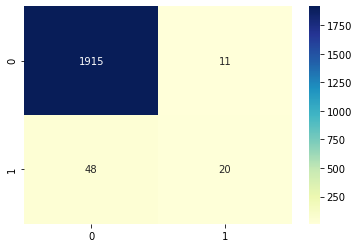

In [64]:
# Model evaluation
rfc.score(X_train_scaled,y_train)
cm=confusion_matrix(y_test,y_pred_rfc)
sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='d')


### 5a. Model Evaluation: Random Forest :Check the random forest classifier model’s performance by printing accuracy, confusion matrix, F1 score and the AUC-ROC curve 


In [73]:
from sklearn.metrics import accuracy_score,classification_report
print("Accuracy Score: ",accuracy_score(y_test,y_pred_rfc))
print("F1 Score: ", f1_score(y_test,y_pred_rfc))
print("Precision Score is",precision_score(y_test,y_pred_rfc))
print("Recall Score is",recall_score(y_test,y_pred_rfc))
print("\n")
print("Classification report: \n", classification_report(y_test,y_pred_rfc))
print("ROC_AUC score: ",roc_auc_score(y_test,y_pred_rfc))

Accuracy Score:  0.9704112337011033
F1 Score:  0.4040404040404041
Precision Score is 0.6451612903225806
Recall Score is 0.29411764705882354


Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1926
           1       0.65      0.29      0.40        68

    accuracy                           0.97      1994
   macro avg       0.81      0.64      0.69      1994
weighted avg       0.96      0.97      0.97      1994

ROC_AUC score:  0.6442031641316963


#### Model summary
1. Accuracy score of our model is 97%. so our model 97% correctly predicts out of total predictions.
   But we cannot conclude our result since our data has imbalanced class. So we look for precision,recall and f1-score    in our data
2. The precision and recall scores are 65% and 29% respectively.
3. F1 score is the harmonic mean of precision and recall, and it performs well on imbalanced dataset as  it takes both false positive and false negative into account. The F1 score is 40 %
4. The ROC_AUC Score is 64.4%

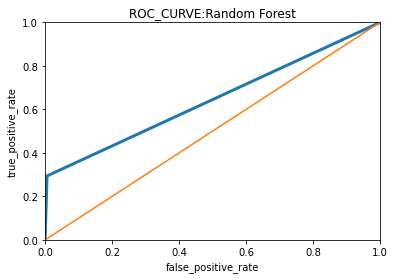

In [95]:
from sklearn.metrics import roc_curve
fpr_rfc, tpr_rfc, threshold_rfc = roc_curve(y_test, y_pred_rfc)
# Plotting the ROC curve for Random Forest model
def plot_roc_curve(fpr_rfc,tpr_rfc):
    plt.plot(fpr_rfc,tpr_rfc,linewidth=3)
    plt.plot([0,1],'-')
    plt.axis([0,1,0,1])
    plt.xlabel("false_positive_rate")
    plt.ylabel("true_positive_rate")
    plt.title("ROC_CURVE:Random Forest")
plot_roc_curve(fpr_rfc,tpr_rfc)

### 4. XGBoost Classifier Model Building 
1.  Build a XGBoost classification Model
2.  Train the model on the Train Data Set 
3.  Print the model summary


In [75]:
#Training our model
import xgboost as xgb
xg_model = xgb.XGBClassifier()
xg_model.fit(X_train_scaled,y_train)
print(xg_model)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)


In [76]:
#Predicting the model
xg_pred = xg_model.predict(X_test_scaled)

In [77]:
#comparing predicted and actual test values 
df_xgb = pd.DataFrame({'Actual': y_test, 'Predicted': xg_pred})
df_xgb.head()

,Actual,Predicted
6432,0,0
1236,0,0
1981,0,0
4192,0,0
692,0,0


0.9879623824451411

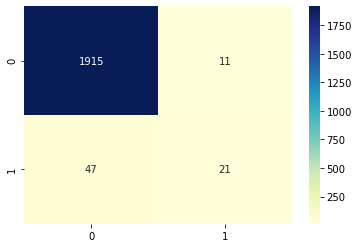

In [80]:
#Model Summary
xg_model.score(X_train_scaled,y_train)
cm=confusion_matrix(y_test,xg_pred)
sns.heatmap(cm,annot=True,cmap="YlGnBu",fmt='d')



### 5b. Model Evaluation : XGBOOST:Check the random forest classifier model’s performance by printing accuracy, confusion matrix, F1 score and the AUC-ROC curve 


In [81]:
print("Accuracy Score: ",accuracy_score(y_test,xg_pred))
print("F1 Score: ", f1_score(y_test,xg_pred))
print("Precision Score is",precision_score(y_test,xg_pred))
print("Recall Score is",recall_score(y_test,xg_pred))
print("\n")
print("Classification report: \n", classification_report(y_test,xg_pred))
print("ROC_AUC score: ",roc_auc_score(y_test,xg_pred))

Accuracy Score:  0.970912738214644
F1 Score:  0.42
Precision Score is 0.65625
Recall Score is 0.3088235294117647


Classification report: 
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      1926
           1       0.66      0.31      0.42        68

    accuracy                           0.97      1994
   macro avg       0.82      0.65      0.70      1994
weighted avg       0.97      0.97      0.97      1994

ROC_AUC score:  0.6515561053081669


#### Model summary
1. The accuracy score is 97%. Thus our model correctly predicts 97% of the samples.But in case of imbalanced class accuracy is not a correct measure. So we look for precision, recall and F1 score.
2. The precision is 66% and recall is 31 %.
3. The F1 score is the Harmonic mean of precision and recall and is a good measure for imbalanced class. The F1 score is 42%.
4. The ROC_AUC score is 65.15%

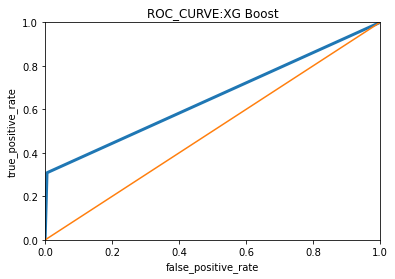

In [96]:
fpr_xgb, tpr_xgb, threshold_xgb = roc_curve(y_test, xg_pred)
# Plotting the ROC curve for Random Forest model
def plot_roc_curve(fpr_xgb,tpr_xgb):
    plt.plot(fpr_xgb,tpr_xgb,linewidth=3)
    plt.plot([0,1],'-')
    plt.axis([0,1,0,1])
    plt.xlabel("false_positive_rate")
    plt.ylabel("true_positive_rate")
    plt.title("ROC_CURVE:XG Boost")
plot_roc_curve(fpr_xgb,tpr_xgb)

### 6. Compare the performance of random forest classification and XGBoost classification models for given dataset 

In [100]:
print("ROC_AUC score for Random Forest Classifier is: ",roc_auc_score(y_test,y_pred_rfc))
print("ROC_AUC score for XgBoost Classifier is : ",roc_auc_score(y_test,xg_pred))
print("\n")
print("Accuracy Score for random Forest: ",accuracy_score(y_test,y_pred_rfc))
print("F1 Score for Random forest: ", f1_score(y_test,y_pred_rfc))
print("\n")
print("Accuracy Score for Xg Boost: ",accuracy_score(y_test,xg_pred))
print("F1 Score for Xg boost: ", f1_score(y_test,xg_pred))

ROC_AUC score for Random Forest Classifier is:  0.6442031641316963
ROC_AUC score for XgBoost Classifier is :  0.6515561053081669


Accuracy Score for random Forest:  0.9704112337011033
F1 Score for Random forest:  0.4040404040404041


Accuracy Score for Xg Boost:  0.970912738214644
F1 Score for Xg boost:  0.42


### Conclusion Summary:
1. We can conclude that XgBoost model is better compared to the Random forest Classifier model.
2. The ROC_AUC score is better for XgBoost compared to the Random forest Classifier
3. Although the accuracy scores are same but we cannot base our conclusion on accuracy scores as our dataset in imbalanced.
4. The F1 score is better metric for imbalanced data and it also indicated that XGBoost is slightly better compared to random forest.
